In [1]:
import torch
import math
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

%matplotlib inline

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

在train_iter中，每个词元对应着一个唯一的数字索引，但是直接将这么多数字索引输入模型中训练十分困难，需要将这些数字索引进一步简化成为特征向量，最简单的转变方法为独热编码（one-hot encoding）</br>
将数字索引映射为互不相同的单位向量，假设一共有N个词元，即词元字典的长度为N，词元的索引范围就是从0到N-1，假设需要第i处的词元，则将创建一个长度为N的全0向量，并且在这个向量中的第i位的值是1。

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

以上便是第0位和第2位的数字索引对应的词元转换位独热编码之后返回的特征向量。

在train_iter函数中，每次小批量采样的格式为（批量大小，时间步长）。在经过one-hot函数处理之后，原本的二维张量会增加一个词元字典长度的维度从而变为三维张量。进一步地，需要将批量大小和时间步长做一个转置，使得最终的三维张量的形状是（时间步长，批量大小，词元字典长度），经过转置之后能更方便通过最外层的维度来更新小批量数据的隐状态。(一个时间步长内提取2个小批量的数据)

In [4]:
X = torch.arange(10).reshape(2,5)
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

初始化神经网络参数

In [5]:
def get_param(vocab_size, num_hiddens, device):
    # 神经网络的输入维度和输出维度都是词汇表的大小
    num_inputs = num_outputs = vocab_size 
    # 初始化
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    # 输入层参数
    W_xh = normal((num_inputs, num_hiddens))
    # 隐藏层参数
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # 整合到一个list中
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    # 求梯度
    for param in params:
        param.requires_grad_(True)
    return params

初始化隐藏层状态

In [6]:
def init_hidden_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

在一个时间步内计算隐藏层状态和输出,循环神经网络模型通过inputs最外层的维度实现循环（inputs的维度为（时间步长，批量大小，词典长度））， 以便逐时间步更新小批量数据的隐状态H。

In [7]:
def rnn(inputs, state, params):
    
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    
    for X in inputs:
        # 使用正切函数作为激活函数
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

整合以上三个函数到一个类中

In [8]:
class RNNModel:
    def __init__(self, vocab_size, num_hiddens, device, get_param, init_state, forward_fn):
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.params = get_param(vocab_size, num_hiddens, device)
        self.init_state = init_state
        self.forward_fn = forward_fn
    
    # X输入的维度是(批量大小，时间步长)
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
        
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

验证输出是否正确

In [9]:
num_hiddens = 512
net = RNNModel(len(vocab),num_hiddens,d2l.try_gpu(),get_param,init_hidden_state,rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

定义预测函数来生成prefix之后的字符或是单词

In [49]:
def predict_(prefix, num_preds, net, vocab, device):
    # 初始化隐藏层
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    # 把最近预测的一项作为预测下一个时间步的输入
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1,1))
    # 将prefix里的词存到state中用来预测
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # 预测num_preds个时间步的词
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [50]:
predict('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller the the th'

梯度裁剪

In [51]:
def grad_clip(net, theta):
    
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    
    norm = torch.sqrt(sum(torch.sum((p.grad **2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

定义训练一个epoch的函数

In [52]:
def train_epoch(net,train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
        
    for X, Y in train_iter:
        #在第一次迭代采样时初始化state
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        # 计算loss
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        Loss = loss(y_hat, y.long()).mean()
        
        # 更新梯度
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            Loss.backward()
            grad_clip(net, 1)
            updater.step()
        else:
            Loss.backward()
            grad_clip(net, 1)
            updater(batch_size=1)
        metric.add(Loss * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

定义训练函数

In [53]:
def train(net, train_iter, vocab, num_epochs, lr, device, use_random_iter=False):
    # 定义损失函数
    loss = nn.CrossEntropyLoss()
    # 画图函数
    animator = d2l.Animator(xlabel='num_epochs', ylabel='preplexity', legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parasmeters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net,train_iter, loss, updater, device, use_random_iter)
        if (epoch+1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
    print(f'困惑度{ppl:.1f}, {speed:.1f}词元/秒{str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度1.0, 47753.5词元/秒cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


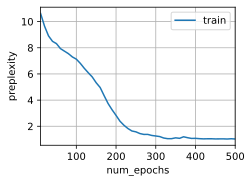

In [54]:
num_epochs, lr = 500, 1
train(net, train_iter, vocab, num_epochs, lr, d2l.try_gpu())